In [1]:
import os
import sys
import logging

# sys.path.append('/home/el2522/.local/lib/python3.8/site-packages')
sys.path.append('/data/master/DS217/users/el2522')

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import torch
import torchtuples as tt
from torch.utils.data import DataLoader
from torch.optim import Adam

np.random.seed(1234)
_ = torch.manual_seed(123)


from pymlrf.SupervisedLearning.torch import train, train_single_epoch, validate_single_epoch
from pymlrf.SupervisedLearning.torch import MetricOrchestrator
from ehr_ts_representations.Models.torch.AE import AutoEncoder as AE
from ehr_ts_representations.Models.torch.encoders.MLP import MLPEncoder as MLP
from ehr_ts_representations.Loss import Loss
from ehr_ts_representations.Datasets.ClustDataset import (
    ClustDataset, ClustDatasetLkbck, ClustCollector
    )

2024-05-17 15:07:48,489 - pymlrf - WARNING - pymlrf environment variable not set. Logging to file will not be performed (__init__.py:51)


In [2]:
# Load the data
data_dir = '/data/master/DS217/users/el2522/'
file_path = os.path.join(data_dir, 'ventDataPrep/intermediate/df_imputed.pkl')
df = pd.read_pickle(file_path)

In [3]:
# Open the file for reading
data_dir = '/data/master/DS217/users/el2522/'
file_path = os.path.join(data_dir, 'EF_test_data_record.pkl')

with open(file_path, 'rb') as file:
    EF_data = pickle.load(file)

EF_id_list = EF_data['encounterId']


/data/master/DS217/users/el2522/TTEAnalysis/TTE_env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
df = pd.get_dummies(df, columns=['diagnosis', 'ethnicity'])

In [5]:
# define vars
demo_cols = ['gender','age', 'weight', 'PIM'] + [x for x in df.columns if 
                                            x.startswith(('ethnicity', 'diagnosis'))]

age_dependent_cols = ['HR', 'systolicBP', 'meanBP', 'diastolicBP']

categoric_cols = ['NMB', 'sedation', 'furosemide', 'vasoActive', 'steroid', 
                  'ventMode_PC', 'ventMode_PS'] # 'ventMode_NIV', 'ventMode_NoSupport'

numerical_cols = ['timestamp', 'MAP','RR(measured)', 'etCO2', 'temp', 'HR', 'SpO2',
       'systolicBP', 'meanBP', 'diastolicBP', 'pH', 'PCO2', 'baseExcess',
       'lactate', 'HCO3', 'WBC', 'Neutrophil', 'Hb', 'fluidBalance', 'FiO2', 'PIP',
       'RR(set)', 'PEEP(set)', 'inspTime', 'PS', 'TVbyWeight'] # 'RRRatio', 'IERatio', 'deltaP', 'mPower', 'SFRatio'



In [6]:
# Convert data type
for col in categoric_cols+['gender','age']+[x for x in df.columns if 
                                            x.startswith(('ethnicity', 'diagnosis'))]:
    df[col] = df[col].astype('int')

# Round the timestamp to the nearest whole number and then convert to int
df[['timestamp', 'LOV']] = np.round(df[['timestamp', 'LOV']]).astype(int)
    
# Identify the timestep of the first instance of NIV or NoSupport for each encounterId:
first_extubation_time = df.groupby('encounterId').apply(
    lambda group: group[(group['airwayStatus_Extubated'] == 1)]['timestamp'].min() 
                  if not group[(group['airwayStatus_Extubated'] == 1)]['timestamp'].empty 
                  else group['timestamp'].iloc[-1],
    include_groups=False
)
df['first_extubation_time'] = df['encounterId'].map(first_extubation_time)

In [7]:
def compute_outcomes_with_censoring(group, cut_off=24*28):
    group.set_index('timestamp', inplace=True)
    
    # Identify the timestep of the first instance of NIV or NoSupport for each encounterId:
    vent_start = group[group.airwayStatus_Intubated==1].first_valid_index()
    vent_end = group[group.airwayStatus_Extubated==1].last_valid_index()
    
    
    # Censoring indicator
    # It's event (0) if we don't have a complete 48-hour observation window post-extubation,
    if (vent_end is None) | (group[['airwayStatus_Intubated', 'airwayStatus_TubeKeptIn']].iloc[-1].sum()!=0):
        if group['ifDeceased'].iloc[0]==1:
            event_description = 'Not Extubated - Deceased'
        else:
            event_description = 'Not Extubated - Alive'
    elif (group['airwayStatus_TubeKeptOut'].iloc[-48:].sum()!=48):
        if group['ifDeceased'].iloc[0]==1:
            event_description = 'No 48h Observation - Deceased'
        else:
            event_description = f'No 48h Observation - Alive'
    elif group['airwayStatus_TubeKeptOut'].iloc[-48:].sum()==48:
        event_description = "Successful Extubation"
    
    vent_end = int(vent_end) if not event_description.startswith('Not Extubated') else int(group.index[-1])
    if (vent_end-vent_start) > cut_off:
        event_description = f'Not Extubated - Cut Off at {cut_off}H'
        vent_end = int(cut_off + vent_start)
        
    num_intub = group.loc[:vent_end].airwayStatus_Intubated.sum()

    return pd.Series({
        'vent_start_time': int(vent_start),
        'vent_end_time': int(vent_end),
        'num_intub': int(num_intub),
        'event_description': event_description,
    })

# Apply function and merge results
cut_off = 24*28
vent_outcome = df.groupby('encounterId').apply(
    lambda x: compute_outcomes_with_censoring(x, cut_off = cut_off),
    include_groups=False
).reset_index()
df = df.merge(vent_outcome, on='encounterId', how='left')


In [8]:
df_pred = df.copy() 
# re-align timestamp
df_pred['timestamp_original'] = df_pred['timestamp']
df_pred['timestamp'] = df_pred.timestamp - df_pred.vent_start_time
df_pred = df_pred[(df_pred.timestamp_original >= df_pred.vent_start_time)]

# left out extra test dataset for comparing with extubation failure task
df_ef = df_pred[df_pred.encounterId.isin(EF_id_list)].copy()
df_ef['encounterId_ordered'] = pd.Categorical(df_ef['encounterId'], categories=EF_id_list, ordered=True)
df_ef = df_ef.sort_values('encounterId_ordered')
df_ef.drop('encounterId_ordered', axis=1, inplace=True)


In [9]:
df_baseline = df_pred[(~df_pred.encounterId.isin(EF_id_list)) & 
                      (~df_pred.event_description.str.contains('Deceased'))].copy() # should include competing risk after

df_baseline['vent_end_time_tmp'] =  np.minimum(df_baseline.first_extubation_time, df_baseline.vent_end_time)
df_baseline = df_baseline[df_baseline.timestamp_original < df_baseline.vent_end_time_tmp] 
        # here we cut-off at first extubation
df_baseline['time_to_event'] = (df_baseline.vent_end_time_tmp-df_baseline.timestamp_original).astype(int)
df_baseline.drop(columns='vent_end_time_tmp', inplace=True)

df_baseline['event'] = ~(df_baseline.event_description.str.startswith('Not Extubated') | (df_baseline.num_intub>1)) 
df_baseline.loc[df_baseline.num_intub>1, 'event_description'] = 'Extubation Failure'


In [10]:
# Get unique encounterIds
id_df = df_baseline[['encounterId', 'event', 'event_description']].drop_duplicates()

# Split the unique encounterIds into train and test sets
id_df_train_val, id_df_test = train_test_split(id_df, stratify = id_df['event_description'],
                                               test_size=0.2)
id_df_train, id_df_val = train_test_split(id_df_train_val, stratify = id_df_train_val['event_description'],
                                               test_size=0.2)

# Filter the original dataframe based on the splits of encounterIds
df_train = df_baseline[df_baseline['encounterId'].isin(id_df_train['encounterId'])]
df_val = df_baseline[df_baseline['encounterId'].isin(id_df_val['encounterId'])]
df_test = df_baseline[df_baseline['encounterId'].isin(id_df_test['encounterId'])]

# # Ensure that the maximum time_to_final_weaning in the test set is less than in the train set
# max_train_time = df_train['time_to_final_weaning'].max()
# df_test = df_test[df_test['time_to_final_weaning'] < max_train_time]

# Standardization for other numerical columns
scaler = MinMaxScaler()
cols_to_transform = demo_cols + categoric_cols + numerical_cols
df_train[cols_to_transform] = scaler.fit_transform(df_train[cols_to_transform])
df_val[cols_to_transform] = scaler.transform(df_val[cols_to_transform])
df_test[cols_to_transform] = scaler.transform(df_test[cols_to_transform]) # Apply same transformation to test data


/tmp/ipykernel_3668109/2863315832.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[cols_to_transform] = scaler.fit_transform(df_train[cols_to_transform])
/tmp/ipykernel_3668109/2863315832.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[cols_to_transform] = scaler.transform(df_val[cols_to_transform])
/tmp/ipykernel_3668109/2863315832.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [11]:
step=12

In [12]:
# def prepare_tabular_data(df, selected_features, tte_col, event_col, step=12):
#     # Calculate trajectory lengths for dynamic stepping
#     df['trajectory_length'] = df.groupby('encounterId')[tte_col].transform('count')
    

#     # Filter the DataFrame by stepping through each group
#     sampled_data = df.groupby('encounterId').apply(lambda group: group.iloc[::step], include_groups=False)
        
#     # Select the required features along with TTE and event columns
#     tabulars_np = sampled_data[selected_features].values.astype('float32')
#     ttes_np = sampled_data[tte_col].values
#     events_np = sampled_data[event_col].values.astype('float32')
    
#     return tabulars_np, (ttes_np, events_np)


def prepare_tabular_data(df, selected_features, tte_col, event_col, step=24):

    # Function to process each group
    def process_group(group):
        # Define bins based on the TTE column using the step size
        bins = np.arange(0, group[tte_col].max() + step, step)
        
        # Digitize the TTE values to find out which bin they fall into
        group['bin_index'] = np.digitize(group[tte_col], bins, right=True) - 1  # Subtract 1 to align with zero indexing
        
        # Select a random occurrence within each bin
        sampled = group.groupby('bin_index').apply(lambda x: x.sample(1), include_groups=False).reset_index(drop=False)
        # Set the TTE to the right edge of the bins (using bin_index to find the right edge)
        sampled['tte'] = (sampled['bin_index'] + 1) * step
                
        return sampled[selected_features + ['tte', tte_col, event_col]]

    # Apply the function to each group and combine results
    sampled_data = df.groupby('encounterId').apply(process_group, include_groups=False).reset_index(drop=False)
        
    # Prepare arrays for machine learning input
    tabulars_np = sampled_data[selected_features].values.astype('float32')
    ttes_np = sampled_data['tte'].values.astype('int')
    events_np = sampled_data[event_col].values.astype('float32')
    y_tracker = sampled_data[['encounterId', tte_col, event_col]]
    
    return tabulars_np, (ttes_np, events_np), y_tracker


# Example usage assuming 'df' is your DataFrame sorted by 'encounterId' and 'timestamp'
X_train, y_train, y_tracker_train = prepare_tabular_data(
    df_train.sort_values(by=['encounterId', 'time_to_event']),  # Make sure data is sorted appropriately
    cols_to_transform,  # Features selected for training
    'time_to_event', 
    'event',
    step=step
)

X_val, y_val, y_tracker_val = prepare_tabular_data(
    df_val.sort_values(by=['encounterId', 'time_to_event']),  # Make sure data is sorted appropriately
    cols_to_transform,  # Features selected for training
    'time_to_event', 
    'event',
    step=step
)

X_test, y_test, y_tracker_test = prepare_tabular_data(
    df_test.sort_values(by=['encounterId', 'time_to_event']),  # Make sure data is sorted appropriately
    cols_to_transform,  # Features selected for training
    'time_to_event', 
    'event',
    step=step
)
########
# tmp
def tmp_handler(labels):
    new_durations = labels[0]
    mask1 = new_durations>240
    new_durations[mask1] = np.ceil(new_durations[mask1]/24)*24
    mask2 = new_durations>360
    new_durations[mask2] = np.ceil(new_durations[mask2]/48)*48
    
    return (new_durations, labels[1])

y_train = tmp_handler(y_train)
y_val = tmp_handler(y_val)
y_test = tmp_handler(y_test)


#########

X_train_val = np.concatenate([X_train, X_val], axis=0)
y_train_val = (np.concatenate([y_train[0], y_val[0]]), np.concatenate([y_train[1], y_val[1]]))

durations_test, events_test = y_test



In [13]:
# refine time steps to take consideration, taking a conservative approach
lower, upper = np.percentile(durations_test, [0, 99])
time_grid = np.arange(lower, upper+1, step=step)

In [14]:
df_train_sampled = df_train
df_val_sampled = df_val

x_y_train = ClustDataset(
    X=pd.DataFrame(X_train),
    y=pd.DataFrame(X_train)
    )
x_y_val = ClustDataset(
    X=pd.DataFrame(X_val),
    y=pd.DataFrame(X_val)
    )

# Wrap the ClustDataset into a DataLoader
clust_collector = ClustCollector()
train_data_loader = DataLoader(x_y_train, batch_size=128, shuffle=True, collate_fn=clust_collector)
val_data_loader = DataLoader(x_y_val, batch_size=128, shuffle=False, collate_fn=clust_collector)

In [15]:
# Define the dimensions for the MLP encoder and decoder
in_features = X_train.shape[-1]
hidden_dims = [in_features, int(in_features/2)]
batch_norm = True
dropout = 0.1
out_features = int(in_features/2)

# Create instances of the MLP class for the encoder and decoder
# encoder = tt.practical.MLPVanilla(in_features, hidden_dims, out_features, batch_norm, dropout)
# decoder = tt.practical.MLPVanilla(out_features, hidden_dims[::-1], in_features, batch_norm, dropout)

encoder = MLP(in_features, hidden_dims, out_features)
decoder = MLP(out_features, hidden_dims[::-1], in_features)

# Define the number of clusters for the AutoEncoder
n_clusters = 10

# Create an instance of the AutoEncoder class
ae_model = AE(encoder=encoder, decoder=decoder, n_clusters=n_clusters)

In [16]:

# Initialize your model, optimizer, and loss function
lr = 1e-4
optimizer = Adam(ae_model.parameters(), lr=lr)

mo = MetricOrchestrator()
mo.reset_orchestrator()
#todo: mo.setup_orchestrator()??

gpu = True
criterion_dict = {}
for i in ["train", "val"]:
    mo.add_metric(f'{i}_reconstruct', {})
#     mo.add_metric(f'{i}_clust', {})
#     mo.add_metric(f'{i}_spread', {})
    _loss_functions = [
        Loss.MultiOutputMSE(mo, prefix=i), 
#         Loss.MultiOutputMSEClust(mo, prefix=i), 
#         Loss.MultiOutputSpread(mo, prefix=i)
    ]
    weights = [1.0]  # These should sum to 1
#     weights = [0.7, 0.1, 0.2]  # These should sum to 1
    criterion_dict[i] = Loss.BalancedLoss(*_loss_functions, lam=weights, gpu=gpu)
    criterion_dict[i].reset_exc_counter()


In [151]:
class EarlyStopping:
    def __init__(self, patience=10, tolerance=0.01, direction= "ls", verbose=False):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
                            Default: 10
            tolerance (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0.01
            direction (Literal["ls", "gr"]): Direction of improvement; "ls" for less (minimizing a metric like loss),
                                            "gr" for greater (maximizing a metric like accuracy).
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.tolerance = tolerance
        self.verbose = verbose
        self.best_value = None
        self.counter = 0
        self.direction = direction
        self.__dir_func = (lambda a, b: a < b) if direction == "ls" else (lambda a, b: a > b)

    def __call__(self, current, previous=None):
        if previous is None:
            # If no previous value given, always continue training
            return False
        if self.best_value is None or self.__dir_func(current, self.best_value - self.tolerance):
            self.best_value = current
            self.counter = 0
            if self.verbose:
                print(f"Improved metric to {current:.6f}, resetting counter.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Counter at {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                return True
        return False


In [153]:

# Training...
epochs = 3
mo, _ = train(
    model=ae_model,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    gpu=gpu,
    optimizer=optimizer,
    criterion=criterion_dict["train"],
    epochs=epochs,
    logger=logging.getLogger(),
    save_dir='./model_checkpoints',
    scheduler=None,
    early_stopping_func=EarlyStopping(patience=5, tolerance=0.0001, direction="ls", verbose=True),
    es_action="stop",
    train_epoch_func=train_single_epoch,
    val_epoch_func=validate_single_epoch,
    mo=mo,
    val_criterion=criterion_dict["val"]
)

0it [00:00, ?it/s]

2024-05-17 13:59:40,195 - pymlrf - DEBUG - First epoch so skipping early stopping evaluation (EarlyStopper.py:60)
Implement final epoch properly


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 3.424782, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 2.977381, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 2.926595, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 2.824262, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 2.553609, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 2.400349, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 2.296603, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 2.147240, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 1.963368, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 1.760636, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 1.645203, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 1.545854, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 1.440737, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 1.312901, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 1.194452, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 1.094998, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 1.001302, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.925592, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.885991, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.861000, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.843151, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.826818, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.812891, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.800213, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.788742, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.776377, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.764980, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.754010, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.740732, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.730240, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.717228, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.704728, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.692785, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.680274, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.669444, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.655465, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.644202, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.632372, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.619665, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.607258, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.594496, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.582371, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.572620, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.561332, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.552306, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.542333, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.534480, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.526663, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.519987, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.513757, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.507313, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.502272, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.496877, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.492737, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.486834, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.482849, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.480381, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.475041, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.470412, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.466182, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.462851, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.459044, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.455787, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.452225, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.449011, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.445529, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.441216, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.438109, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.435013, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.430496, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.427523, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.423302, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.419328, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.415961, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.411245, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.408788, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.404209, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.400759, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.396366, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.392887, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.389939, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.386811, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.383286, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.380586, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.376957, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.374034, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.370953, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.368178, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.365497, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.363008, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.360998, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.357905, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.355421, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.352559, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.350872, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.348950, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.347165, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.345248, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.342863, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.340060, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.338668, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.337400, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.335582, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.334269, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.331628, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.329592, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.328193, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.326209, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.325084, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.321531, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.318973, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.317462, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.315698, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.314225, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.311038, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.309920, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.308061, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.305602, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.304276, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.303000, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.301406, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.298676, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.297989, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.296909, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.295257, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.293203, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.292776, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.291481, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.290981, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.289337, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.288240, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.287443, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.286334, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.285967, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.284210, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.283920, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.283297, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.282924, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.282070, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.281389, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.279957, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.279155, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.278592, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.277961, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.276498, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.274861, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.274255, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.273667, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.272214, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.271535, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.270503, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.269685, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.267856, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 2/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.266262, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.265871, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.265141, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.263984, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.263752, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.262361, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.261444, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.260627, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.259859, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.259301, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.258595, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.258292, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.257873, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.256644, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.256296, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.255297, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.255165, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.254959, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.253951, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.253555, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.252333, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.252214, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.251497, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.251042, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.250743, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.249662, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.248336, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 2/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.247140, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.246727, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.246343, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.245313, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.245178, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.244723, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.243775, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.242216, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.241903, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.240886, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 2/5


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 3/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.239572, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.239418, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.238271, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.237494, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.237135, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 2/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.235971, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.235750, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.235357, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.234546, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.233877, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 2/5


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 3/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.233400, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.233249, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.233058, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.231808, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.230807, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 2/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.230153, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.229913, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.228824, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.227955, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.227724, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.226725, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.226398, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.226221, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.225841, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.224683, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.224280, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.222765, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 2/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.222414, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.222058, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.221922, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.221674, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.220940, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.220332, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.219529, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.219299, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.218411, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.217910, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.217120, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.216273, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 2/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.215270, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.215119, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.214467, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.214110, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.212584, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.212153, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.211916, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.210928, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.210290, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.209371, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.208740, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 2/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.207728, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.206941, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.206424, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.205011, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.204837, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.203868, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.203149, resetting counter.


0it [00:00, ?it/s]

Implement final epoch properly


No improvement. Counter at 1/5


0it [00:00, ?it/s]

Implement final epoch properly


Improved metric to 0.201909, resetting counter.


0it [00:00, ?it/s]

In [17]:
import torch

def load_checkpoint(model, optimizer, filename="mdl_chkpnt_epoch_1.pt"):
    """
    Load a model checkpoint.
    
    Args:
        model (torch.nn.Module): The model that you want to load the checkpoint into.
        optimizer (torch.optim.Optimizer): The optimizer used for training the model.
        filename (str): Path to the checkpoint file.
        
    Returns:
        int: The epoch number at which this checkpoint was saved.
    """
    # Make sure to load the checkpoint according to the device
    checkpoint = torch.load(filename, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']  # If you want to use it
    
    print(f"Checkpoint loaded: {filename} at epoch {epoch}")
    print(f"Loss at checkpoint: {loss}")
    
    return epoch

# Usage
model = ae_model  # Your model
optimizer = optimizer  # Your optimizer
filename = './model_checkpoints/mdl_chkpnt_epoch_367.pt'  # Adjust the path and filename as needed

last_epoch = load_checkpoint(model, optimizer, filename)

# Continue training or evaluation from here


Checkpoint loaded: ./model_checkpoints/mdl_chkpnt_epoch_367.pt at epoch 367
Loss at checkpoint: 0.18527833439076125


In [131]:
mo_df = mo.all_metrics_to_df()
epoch_mo_df = mo_df[mo_df["metric_name"].isin(['epoch_train_loss','epoch_val_loss'])]

for i in ["train", "val"]:
    for sub_m in ['reconstruct', 'clust', 'spread']:
        # Filter the DataFrame for the specific metric
        _tmp = mo_df[mo_df["metric_name"] == f"{i}_{sub_m}"]
        _tmp = _tmp.reset_index()
        steps_per_epoch = _tmp.shape[0]/epochs

        # Extract step numbers from the index names
        _tmp['step'] = _tmp['index'].str.replace('exc_', '').astype(int)

        # Calculate which epoch each step belongs to
        _tmp['epoch'] = (_tmp['step'] // steps_per_epoch) + 1

        # Group by the newly calculated 'epoch' and compute the mean of 'raw_vals'
        _tmp_grouped = _tmp.groupby('epoch')['raw_vals'].mean().reset_index()
        _tmp_grouped['metric_name'] = f"epoch_{i}_{sub_m}"

        # Concatenate the current data to the main DataFrame
        _tmp_grouped['epoch'] = _tmp_grouped['epoch'].apply(lambda x: f"epoch_{int(x)}")

        # Set the index to 'step' for easier concatenation and consistency
        _tmp_grouped.set_index('epoch', inplace=True)

        # Concatenate the current data to the main DataFrame
        epoch_mo_df = pd.concat([epoch_mo_df, _tmp_grouped])

# Reset the index to use it in pivot
epoch_mo_df.rename_axis('epoch', inplace=True)
epoch_mo_df.reset_index(inplace=True)
epoch_mo_df['epoch'] = epoch_mo_df['epoch'].str.replace('epoch_', '').astype(int)

# Pivot the DataFrame to wide format
pivot_df = epoch_mo_df.pivot(index='epoch', columns='metric_name', values='raw_vals')
pivot_df.reset_index(inplace=True)
pivot_df.columns.name = None  # Clean up the columns name to remove 'metric_name'

with open(os.path.join('./model_checkpoints/evals.pkl'), "wb") as file:
    pickle.dump(pivot_df, file)

pivot_df


,epoch,epoch_train_clust,epoch_train_loss,epoch_train_reconstruct,epoch_train_spread,epoch_val_clust,epoch_val_loss,epoch_val_reconstruct,epoch_val_spread
0,1,8.756074,7.128835,8.751823,0.634754,7.242378,5.916216,7.235458,0.635791
1,2,5.537339,4.53485,5.502685,0.646181,3.791126,3.134043,3.749148,0.652635
2,3,3.375194,2.777325,3.298603,0.653919,3.050879,2.522971,2.981397,0.654525
3,4,3.15172,2.567507,3.031256,0.652276,3.001219,2.461815,2.902848,0.648498
4,5,3.146569,2.496599,2.933169,0.643619,2.911122,2.355806,2.766595,0.640383
...,...,...,...,...,...,...,...,...,...
95,96,1.945982,0.747289,0.531209,0.904219,1.354327,0.666589,0.503384,0.893938
96,97,1.952178,0.746678,0.528264,0.908376,1.41318,0.666271,0.499505,0.8765
97,98,1.942579,0.744527,0.525568,0.911857,1.329355,0.66235,0.497493,0.905846
98,99,1.93675,0.741054,0.522604,0.907781,1.454538,0.669467,0.494755,0.888421


In [20]:
from pycox.models import DeepHitSingle
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pycox.models.loss import rank_loss_deephit_single
import functools


from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.functions import StepFunction
from sksurv.metrics import (
    concordance_index_censored as c_index,
    cumulative_dynamic_auc,
    integrated_brier_score,
    as_integrated_brier_score_scorer
)
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.nonparametric import kaplan_meier_estimator

from sklearn.utils import resample
from sklearn.model_selection import KFold


In [21]:
labtrans = DeepHitSingle.label_transform(cuts=np.unique(y_train[0]).astype(float))  # scheme='quantiles'
y_train_disc = labtrans.fit_transform(*y_train)
y_val_disc = labtrans.transform(*y_val)

labtrans = DeepHitSingle.label_transform(cuts=np.unique(y_train[0]).astype(float))  # scheme='quantiles'
y_train_val_disc = labtrans.fit_transform(*y_train_val)


/data/master/DS217/users/el2522/TTEAnalysis/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


In [22]:

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

def extract_features(dataset, model, include_clust_assign=False, scaler=None):
    """Extract features from a dataset using a pretrained model, 
    optionally including cluster assignments, and standardize features.

    Args:
        dataset (Union[np.ndarray, torch.Tensor]): Dataset to process.
        model (torch.nn.Module): Pretrained model used for feature extraction.
        include_clust_assign (bool): Whether to concatenate one-hot encoded cluster assignments with the latent vectors.
        scaler (StandardScaler, optional): A pre-fitted scaler for standardizing features; if None, a new scaler will be fitted.

    Returns:
        np.ndarray: Processed features, possibly concatenated with one-hot encoded cluster assignments and standardized.
    """
    # Ensure dataset is a torch.Tensor
    if not isinstance(dataset, torch.Tensor):
        dataset = torch.tensor(dataset, dtype=torch.float32)
    
    # Align dataset device with model device
    model_device = next(model.parameters()).device
    dataset = dataset.to(model_device)
    
    # Forward pass through the model in no_grad context
    with torch.no_grad():
        output = model(dataset)
        features = output.encoded.cpu().detach().numpy()

        if include_clust_assign:
            clust_assign = output.clust_assign.cpu().detach().numpy()
            encoder = OneHotEncoder(sparse_output=False)
            clust_assign_encoded = encoder.fit_transform(clust_assign.reshape(-1, 1))
            features = np.hstack((features, clust_assign_encoded))
    
    # Standardize features
    if scaler is None:
        scaler = MinMaxScaler()
        features = scaler.fit_transform(features)
    else:
        features = scaler.transform(features)
    
    return features.astype(np.float32), scaler

ae_model.eval()
for param in ae_model.parameters():
    param.requires_grad = False

# For training, fit a new scaler
Z_train, scaler = extract_features(X_train, ae_model, include_clust_assign=False)

# For validation and testing, use the existing scaler
Z_val, _ = extract_features(X_val, ae_model, include_clust_assign=False, scaler=scaler)
Z_test, _ = extract_features(X_test, ae_model, include_clust_assign=False, scaler=scaler)


In [24]:
in_features = Z_train.shape[-1]
out_features = labtrans.out_features
hidden_dims = [64, 64, 32]
batch_norm = True
dropout = 0.5

# net = RNN(input_dim = in_features, output_dim = out_features, dims = hidden_dims, 
#           rnn_n_layers=2, rnn_kwargs={'dropout': 0.5})

# net = MLP(input_dim = in_features, output_dim = out_features, dims = hidden_dims

net = tt.practical.MLPVanilla(in_features, hidden_dims, out_features, batch_norm, dropout)



In [25]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)
deephit_mlp_model = DeepHitSingle(net, optimizer, alpha=0.5, sigma=0.3, duration_index=labtrans.cuts)

In [26]:
import functools

# Set sigma to a fixed value, e.g., 0.3
fixed_sigma_rank_loss = functools.partial(rank_loss_deephit_single, sigma=0.3)

In [27]:
epochs = 100
batch_size = 128

callbacks = [
    tt.callbacks.EarlyStopping(
        patience=5,          # Number of epochs with no improvement after which training will be stopped
        min_delta=0.0001,     # Minimum change considered as an improvement
    ),
#     tt.callbacks.LRSchedulerBatch(torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)),
    tt.callbacks.ClipGradNorm(net, max_norm=1.0),
]

log = deephit_mlp_model.fit(Z_train, y_train_disc, batch_size, epochs, 
                            callbacks, num_workers=8, val_data=(Z_val, y_val_disc), 
                            metrics={'RankLoss': fixed_sigma_rank_loss})


0:	[16s / 16s],		train_loss: 1.6750,	train_RankLoss: 0.3964,	val_loss: 1.5174,	val_RankLoss: 0.3683
1:	[14s / 30s],		train_loss: 1.5597,	train_RankLoss: 0.3897,	val_loss: 1.4471,	val_RankLoss: 0.3622
2:	[10s / 41s],		train_loss: 1.5029,	train_RankLoss: 0.3896,	val_loss: 1.4130,	val_RankLoss: 0.3575
3:	[5s / 46s],		train_loss: 1.4655,	train_RankLoss: 0.3866,	val_loss: 1.3934,	val_RankLoss: 0.3536
4:	[5s / 51s],		train_loss: 1.4476,	train_RankLoss: 0.3827,	val_loss: 1.3829,	val_RankLoss: 0.3504
5:	[4s / 56s],		train_loss: 1.4330,	train_RankLoss: 0.3766,	val_loss: 1.3798,	val_RankLoss: 0.3489
6:	[5s / 1m:1s],		train_loss: 1.4254,	train_RankLoss: 0.3743,	val_loss: 1.3740,	val_RankLoss: 0.3460
7:	[4s / 1m:6s],		train_loss: 1.4158,	train_RankLoss: 0.3697,	val_loss: 1.3675,	val_RankLoss: 0.3425
8:	[4s / 1m:11s],		train_loss: 1.4118,	train_RankLoss: 0.3674,	val_loss: 1.3635,	val_RankLoss: 0.3397
9:	[4s / 1m:16s],		train_loss: 1.4090,	train_RankLoss: 0.3669,	val_loss: 1.3594,	val_RankLoss: 0.33

In [28]:
# Given your split, now let's create the structures for the survival analysis
def create_survival_data(durations, events):
    return Surv.from_arrays(event=events, time=durations)

# Prepare survival data for fitting the models
y_train_val_surv = create_survival_data(y_train_val[0], y_train_val[1])                                        
y_test_surv = create_survival_data(durations_test, events_test)

deephit_mlp_surv = deephit_mlp_model.predict_surv_df(Z_test)


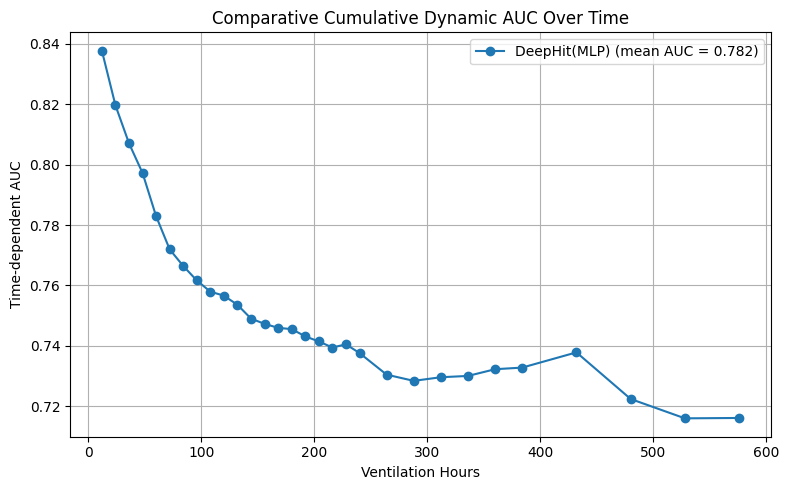

In [29]:

time_grid_deephit = labtrans.cuts
mask_deephit = (time_grid_deephit<=time_grid.max()) & (time_grid_deephit>=time_grid.min())
time_grid_deephit = time_grid_deephit[mask_deephit]
deephit_mlp_risk_scores = (1-deephit_mlp_surv.transpose().values)[:, mask_deephit] # use predict_cif if having compte risks
deephit_mlp_auc, deephit_mlp_mean_auc = cumulative_dynamic_auc(y_train_val_surv, y_test_surv, 
                                                               deephit_mlp_risk_scores, time_grid_deephit)


# Visualization
plt.figure(figsize=(8, 5))

plt.plot(time_grid_deephit, deephit_mlp_auc, "o-", label=f"DeepHit(MLP) (mean AUC = {deephit_mlp_mean_auc:.3f})")
plt.xlabel("Ventilation Hours")
plt.ylabel("Time-dependent AUC")
plt.title("Comparative Cumulative Dynamic AUC Over Time")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
deephit_mlp_ev = EvalSurv(deephit_mlp_surv, durations_test, events_test, censor_surv='km')


In [31]:

models_to_eval = [
#     ('Kaplan-Meier', km_ev),
#     ('Cox-PH', cph_ev),
#     ('RSF', rsf_ev),
#     ('DeepHit-RNN', deephit_ev),
    ('DeepHit-MLP', deephit_mlp_ev),
#     ('DeepSurv-RNN', deepsurv_ev),
#     ('DeepSurv-MLP', deepsurv_mlp_ev),
#     ('Baseline', baseline_ev)
    # Add more models as necessary
]

model_results = []  # List to store result dictionaries

for model_name, ev in models_to_eval:
#     time_grid = np.arange(durations_test.min(), durations_test.max() + 1, step=12)
    c_index = ev.concordance_td(method='antolini')
    bs = ev.brier_score(np.array([24])).values[0]
    integrated_bs = ev.integrated_brier_score(time_grid)
    mae, rmse, mape = ev.compute_error_metrics()

    # Append results as a dictionary to the list
    model_results.append({
        'Model': model_name,
        'C-Index': c_index,
        'Brier Score at 24h': bs,
        'Integrated Brier Score': integrated_bs,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    })

# Convert list of dictionaries to DataFrame at the end
results_df = pd.DataFrame(model_results)

results_df

,Model,C-Index,Brier Score at 24h,Integrated Brier Score,MAE,RMSE,MAPE (%)
0,DeepHit-MLP,0.727192,0.136742,0.11299,49.855582,84.251067,88.578952


In [32]:
# Prepare the dictionary for median survival times
median_survival_times = {model: ev.median_survival_times() for model, ev in models_to_eval}
y_tracker_test['durations_test'] = durations_test
y_compare_df = pd.concat([y_tracker_test, pd.DataFrame(median_survival_times)], axis=1)


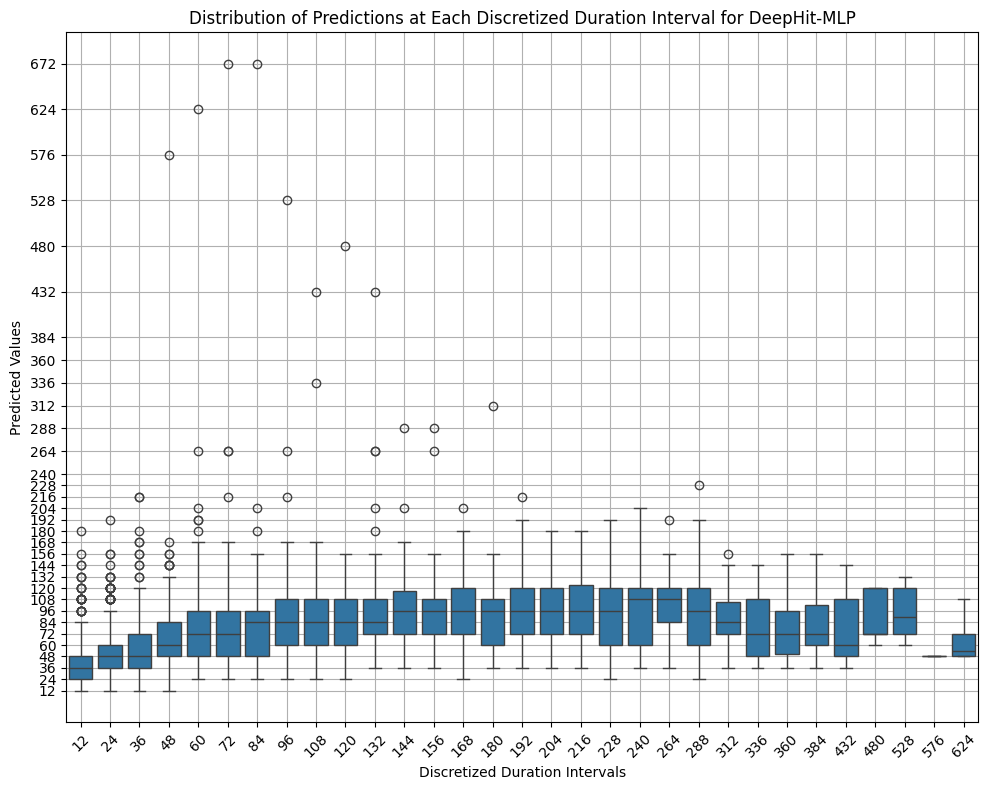

In [33]:
import seaborn as sns

model_column = 'DeepHit-MLP'
# Select only necessary columns and filter events
tmp_df = y_compare_df[y_compare_df.event == 1][['durations_test', model_column]]

# Plotting using seaborn for more elegant output
plt.figure(figsize=(10, 8))
sns.boxplot(x='durations_test', y=model_column, data=tmp_df)
plt.xticks(rotation=45)
plt.yticks(ticks=labtrans.cuts, labels=[f"{int(label)}" for label in labtrans.cuts])

plt.title(f'Distribution of Predictions at Each Discretized Duration Interval for {model_column}')
plt.xlabel('Discretized Duration Intervals')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def drawChartFrame(h, df, cols): 
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    tableau20 = [(31, 119, 180), (174, 199, 232), (247, 182, 210), (255, 187, 120),    
                 (44, 160, 44), (140, 86, 75), (255, 152, 150),  (214, 39, 40),  
                 (148, 103, 189), (197, 176, 213), (152, 223, 138), (196, 156, 148),    
                 (227, 119, 194), (255, 127, 14), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
#     tableau20 = [(227, 119, 194), (148, 103, 189), (255, 127, 14), (44, 160, 44),    
#                  (31, 119, 180), (140, 86, 75),  (214, 39, 40), (255, 152, 150),  
#                  (174, 199, 232), (197, 176, 213), (152, 223, 138), (196, 156, 148),    
#                  (255, 187, 120), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
#                  (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 

    tableau20 = [(r / 255., g / 255., b / 255.) for r, g, b in tableau20]
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(22, 15), 
                                   gridspec_kw={'height_ratios': [5, 1]})
    plt.rcParams.update({'font.size': 22})

    df_filtered = df[df['encounterId'] == h].copy()
    max_hour = int(df_filtered['timestamp'].max())
    x_ticks = np.arange(0, max_hour+1, 12 if max_hour > 24 else 1)

    # Predefine colors for 'inspTime' and 'PEEP(set)'
    color_dict = {'inspTime': tableau20[3], 'PEEP(set)': tableau20[4]}  # adjust as needed

    for i, vent_mode in enumerate(['ventMode_NoSupport', 'ventMode_NIV',  'ventMode_PS', 'ventMode_PC']):
        if vent_mode in df_filtered.columns:
            mask = df_filtered[vent_mode] == 1
            df_filtered.loc[mask, 'group'] = (mask != mask.shift()).cumsum()
            grouped = df_filtered[mask].groupby('group')
            for _, group in grouped:
                start_time = group['timestamp'].min()
                end_time = group['timestamp'].max() + 1
                ax1.fill_between([start_time, end_time], 0, 100, color=tableau20[i], alpha=0.2)
                ax1.text(start_time, 102, vent_mode.replace('ventMode_', ''), color=tableau20[i], fontsize=20, rotation=45)

    for i, v in enumerate(cols):
        if v in df_filtered.columns:
            color = color_dict.get(v, tableau20[(i + 6) % len(tableau20)])  # use predefined color if available
            ax1.step(df_filtered['timestamp'], df_filtered[v], color=color, 
                     lw=1.5, where='post', label=v)
    ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=20)
    ax1.set_yticks(np.arange(0, 120, 10))
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels([])
    ax1.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)
    
    zoom_range = (0, 2.0)
    zoom_range_len = int(zoom_range[1]-zoom_range[0])

    for i, v in enumerate(['inspTime']):
        if v in df_filtered.columns:
            color = color_dict.get(v, tableau20[(i +6) % len(tableau20)])  # use predefined color if available
            ax2.step(df_filtered['timestamp'], df_filtered[v], color=color, lw=2.5, where='post', label=v)

    ax2.set_ylim(zoom_range)
    ax2.set_yticks(np.linspace(zoom_range[0], zoom_range[1], 5))
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_ticks, rotation=45, fontsize=20)
    ax2.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)
    ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=20)

    plt.tight_layout()
    fig.text(0.45, 0.00, 'Episode Timestamp', ha='center', va='center', fontsize=26)
    fig.text(0.00, 0.5, 'Measurement Value', ha='center', va='center', rotation='vertical', fontsize=26)

    plt.show()


In [ ]:
numeric_action_col = ['FiO2', 'PIP', 'RR(set)', 'PEEP(set)', 'inspTime', 'PS']

drawChartFrame(h='5473', df=df, cols=numeric_action_col)
# drawChartFrame(h='10657', df=df, cols=numeric_action_col)


### Get cluster results on df_test